In [65]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 1500)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_circles
import networkx as nx
from scipy import linalg
from sklearn.cluster import KMeans as sklearnKMeans

# Politcal blogs dataset [35 points]

We will study a political blogs dataset first compiled for the paper Lada A. Adamic and Natalie Glance,
“The political blogosphere and the 2004 US Election”, in Proceedings of the WWW-2005 Workshop on the
Weblogging Ecosystem (2005). The dataset nodes.txt contains a graph with n = 1490 vertices (“nodes”)
corresponding to political blogs. Each vertex has a 0-1 label (in the 3rd column) corresponding to the
political orientation of that blog. We will consider this as the true label and try to reconstruct the true label
from the graph using the spectral clustering on the graph. The dataset edges.txt contains edges between the
vertices. You may remove isolated nodes (nodes that are not connected any other nodes).

1. Assume the number of clusters in the graph is k. Explain the meaning of k here intuitively

2. Use spectral clustering to find the k = 2, k = 3, and k = 4 clusters in the network of
political blogs (each node is a blog, and their edges are defined in the file edges.txt). Then report the
majority labels in each cluster, when k = 2, 3, 4, respectively. For example, if there are k = 2 clusters,
and their labels are {0, 1, 1, 1} and {0, 0, 1} then the majority label for the first cluster is 1 and for
the second cluster is 0. It is required you implementing the algorithms yourself rather than
calling from a package.

In [33]:
#load data
edges = pd.read_csv('edges.edgelist', sep='\t', header=None, names=['from','to'])
nodes = pd.read_csv('nodes.txt', sep='\t', header=None, names=['node', 'blog', 'class', 'source'])

print('Total nodes in file: ',len(nodes))

Total nodes in file:  1490


In [34]:
#remove nodes that are isolated (has no edges)

#get all nodes in nodes list
nodes_in_nodes_list = nodes.node.values

#create a set of all unique nodes in the 'from' list
nodes_in_edges_list_from = edges['from'].unique()
#create a set of all unique nodes in the 'to' list
nodes_in_edges_list_to = edges['to'].unique()
#take the union of the two sets
nodes_in_edges = np.union1d(nodes_in_edges_list_from, nodes_in_edges_list_to)

#isolated nodes are those in nodes list that don't appear in the edge lists
#take the intersection of the two which will remove the isolated nodes
nodes_in_clusters = np.intersect1d(nodes_in_nodes_list, nodes_in_edges)

#remove isolated nodes from the nodes list
nodes = nodes[nodes.node.isin(nodes_in_clusters)].reset_index().drop('index',axis=1)

print('Total connected nodes: ', len(nodes))

Total connected nodes:  1224


In [35]:
def create_A_matrix(nodes: np.array, edges: np.array) -> np.array:
    
    #get the total number of nodes (largest node in nodes list)
    m = max(nodes)+1
    
    #create an empty m x m matrix
    A = np.zeros((m,m))
    
    #fill out adjacency matrix with edges
    for nodeA, nodeB in edges:
        A[nodeA, nodeB] = 1
        A[nodeB, nodeA] = 1

    
        
    
    return A[nodes[:,None], nodes]

In [42]:
def create_D_matrix(A: np.array) -> np.array:
    
    #total connections for a node is the sum of adjacencies from A matrix
    sums = np.sum(A, axis=1)
    
    #D is then just a diagonal matrix of the sums
    D = np.diag(sums)
    
    return D

In [43]:
def create_L_matrix(nodes: np.array, edges: np.array) -> np.array:
    
    A = create_A_matrix(nodes, edges)
    
    D = create_D_matrix(A)
    
    L = D - A
    
    return L

In [49]:
def eigens(L: np.array, k: int) -> np.array:
    
    #eigenvalues and eigenvectors of L matrix
    eigvals, eigenvects = linalg.eig(L)
    
    #eigenvals and eigenvecs are guaranteed to be sorted
    #sort the eigenvals
    sorted_indices = np.argsort(eigvals)
    sorted_ = eigvals[sorted_indices]
    
    #sort eigenvector columns by the sorted eigenvalues
    #cast from type(complex) to type(real)
    eigenvects = np.real(eigenvects[:, sorted_indices])
    
    #eigenvalues cast from type(complex) to type(real)
    eigvals = np.real(sorted_)
    
    #return vals, vects up to k columns
    return eigvals, eigenvects[:, :k]

In [63]:
class Distances:
    '''
    This class is responsible for all distance calculations. Supported distance metrics are from the set
    {eucl, eucl_squared, manhattan, minkowski}. Each method underneath calls the minkowski methods since
    each metric is a variant of the minkowski distance with respect to a different power, p.
    '''
    def __init__(self, distance: str) -> None:
        '''
        inputs
        ------
        distance (str) -> The distance metric desired from the set {eucl, eucl_squared, manhattan, minkowski}
        '''
        assert distance in ('eucl', 'eucl_squared', 'manhattan', 'minkowski'), 'Distance "{}" not understood. Please choose from ("eucl" | "eucl_squared" | "manhattan" | "minkowski")'.format(distance)
        self.distance = distance
        
    def _calculate_distance(self, p1: np.array, p2: np.array, p=None) -> np.array:
        
        
        if self.distance == 'eucl':
            return self._euclidean(p1, p2)
        
        elif self.distance == 'eucl_squared':
            return self._euclidean(p1, p2)**2
        
        elif self.distance == 'manhattan':
            return self._manhattan(p1, p2)
        
        elif self.distance == 'minkowski' or (p>2 or p<1):
            return self._minkowski(p1, p2, p)
        
    def _euclidean(self, p1: np.array, p2:np.array) -> np.array:
        '''
        inputs
        ------
        p1: array -> single observation point of dimension (1 x m)
        p2: array -> k-cluster centroids/medoids dimension (k x m)

        outputs
        -------
        eucl: array -> euclidean distance of p1 and p2 dimension (kx 1)
        '''
        
        assert p1.shape[0] == 1, 'wrong dimension for euclidean distance. p1 shape[0] = {}'.format(p1.shape[0])
        assert p2.shape[1] == p1.shape[1], 'dimension mismatch for p1 and p2 euclidean distance. p1 {} and p2 {}'.format(p1.shape, p2.shape)
        
        eucl = self._minkowski(p1, p2, 2)
        
        return eucl
    
    def _manhattan(self, p1: np.array, p2: np.array) -> np.array:
        '''
        inputs
        ------
        p1: array -> single observation point of dimension (1 x m)
        p2: array -> k-cluster centroids/medoids dimension (k x m)

        outputs
        -------
        manhan: array -> manhattan distance of p1 and p2 dimension (kx 1)
        '''
        
        assert p1.shape[0] == 1, 'wrong dimension for euclidean distance. p1 shape[0] = {}'.format(p1.shape[0])
        assert p2.shape[1] == p1.shape[1], 'dimension mismatch for p1 and p2 euclidean distance. p1 {} and p2 {}'.format(p1.shape, p2.shape)
        
        manhan = self._minkowski(p1, p2, 1)
        return manhan
    
    def _minkowski(self, p1: np.array, p2: np.array, p: int) -> np.array:
        '''
        inputs
        ------
        p1: array -> single observation point of dimension (1 x m)
        p2: array -> k-cluster centroids/medoids dimension (k x m)

        outputs
        -------
        mink: array -> manhattan distance of p1 and p2 dimension (kx 1)
        '''
        
        assert p1.shape[0] == 1, 'wrong dimension for euclidean distance. p1 shape[0] = {}'.format(p1.shape[0])
        assert p2.shape[1] == p1.shape[1], 'dimension mismatch for p1 and p2 euclidean distance. p1 {} and p2 {}'.format(p1.shape, p2.shape)
        
        mink = np.sum(np.abs(p1-p2)**p, axis=1)**(1/p)
        return mink

    
  


    
class RandomInit:
    def __init__(self, method: str)-> None:
        '''
        This class is responsible for randomly initializing centroids for either kmeans or kmedoids algorithms
        
        inputs
        ------
        method: (str) -> type of initialization need (kmedoids | kmeans)
        '''
        assert method in ('kmedoids', 'kmeans'), 'RandomInit method "{}" not understood. Please choose (kmedoids | kmeans)'.format(method)
        self.method = method
        
        
    def _initialize(self, x: np.array, k: int):
        if self.method == 'kmedoids' and x is None:
            raise Exception('Invalid Parameter - method chosen "kmedoids" but no data given')
        elif self.method == 'kmedoids' and k is None:
            raise Exception('Invalid Parameter - method chosen "kmedoids" but no k given')
        
        if self.method == 'kmeans' and k is None:
            raise Exception('Invalid Parameter - method chosen "kmeans" but no k given')
        elif self.method == 'kmeans' and x is None:
            raise Exception('Invalid Parameter - method chosen "kmeans" but no data given')
            
        if self.method == 'kmedoids':
            return self._kmedoids_init(x=x, k=k)
        
        elif self.method == 'kmeans':
            return self._kmeans_init(k=k, x=x)

    def _kmedoids_init(self, x: np.array, k: int)->list:
        '''
        initializes k kmedoid cluster centers by randomly selecting k data points from
        the input data
        
        inputs
        ------
        x: np.array -> The training data of shape (m,n)
        k: int -> The number of desired cluster centers
        
        outputs
        -------
        clusters: np.array -> k randomly selected data points to be the cluster centroids
        
        '''
        
        #holds the randomly selected data point indices
        cluster_idxs = []
        
        for i in range(k):
            #random select a datapoint index
            rand_cluster = np.random.randint(0, len(x))
            #if this point has been previously selected, select another one
            while rand_cluster in cluster_idxs:
                rand_cluster = np.random.randint(0, len(x))
            #add new data point index
            cluster_idxs.append(rand_cluster)
        #return data points located at the randomly chosen indices
        return x[cluster_idxs]
    
    def _kmeans_init(self, x: np.array, k: int) -> np.array:
        '''
        initializes k random cluster centroids by randomly selecting k values for 
        each dimension's domain in x
        
        inputs
        ------
        x: np.array -> The training data of shape (m,n)
        k: int -> the number of desired cluster centers
        
        outputs
        -------
        rand_centroids: np.array -> k randomly initialized centroids of shape (k,n)
        '''
        #get the min value for each column in x
        min_domain = np.min(x, axis=0)
        #get the max value for each column in x
        max_domain = np.max(x, axis=0)
        #get the shape of x
        m,n = x.shape
        
        #randomly generated k cluster centroids between the low and hi domains for each column
        rand_centroids = np.random.uniform(low=min_domain, high=max_domain, size=(k,n))
        
        return rand_centroids
                    

                
                
                
class KMeans:
    def __init__(self, k: int, distance_metric: str, p=None, iterations=1000, verbose=True) -> None:

        self.k = k
        self.distance = Distances(distance=distance_metric)
        self.initializer = RandomInit(method='kmeans')
        self.p = p
        self.iterations = iterations
        self.verbose = verbose
        self.converged = False
        
    def fit(self, x):
        m,n = x.shape
        
        #initialize dict to accumulate cost for each centroid
        self.centroid_costs = {c:0 for c in range(self.k)}
        
        #initialize empty array to hold cluster assignments
        self.cluster_assignments = np.zeros((m,1))
        
        #randomly initialize k clusters
        self.cluster_centers = self.initializer._initialize(x=x, k=self.k)
        
        #begin cluster assignment
        for i in range(self.iterations):
            if self.verbose:
                print('Iteration', i)
                
            #check if we have converged
            if self.converged:
                if self.verbose:
                    print('Converged!')
                return
            
            #assign each point to a cluster
            self._assign(x)
            
            #keep a copy of the current centroids
            old_centroids = self.cluster_centers.copy()

            #update cluster centroids
            self._update_centroids(x)
            
            #check if old_centroids are equal to new centroids - no change means we have converged
            if (old_centroids == self.cluster_centers).all():
                self.converged = True

            #reset the costs in preparation for the next cycle
            self.centroid_costs = {c:0 for c in range(self.k)}
            
            
            
    def _assign(self, x):
        #classify each data point by calculating distances
        for i in range(x.shape[0]):
            
            #isolate a single data point
            current_data_point = x[i,:].reshape(1,-1)
                
            #calculate the distance of the current datapoint to each centroid
            distance = self.distance._calculate_distance(current_data_point, self.cluster_centers, self.p)

            #the cluster assignment for current point is the argmin of distance
            assignment = np.argmin(distance)

            #get the cost associated with this assignment - this is located at the position of the argmin (assignment)
            cost = distance[assignment]
            
            #save assignment
            self.cluster_assignments[i] = assignment
            
            #update the cost for the current centroid
            self.centroid_costs[assignment] += cost
            
    def _update_centroids(self, x):

            #for each cluster
            for pos, c in enumerate(range(self.k)):

                #get all data points that exist in cluster c
                cx = x[(self.cluster_assignments == c).ravel()]
                
                if cx.any().any():
                    #calculate the positional mean
                    cluster_mean = np.mean(cx, axis=0)

                    #update the cluster centroid with the mean
                    self.cluster_centers[pos] = cluster_mean

In [ ]:
def draw_graph(G):
    plt.figure(figsize=(20,15))
    pos = nx.spring_layout(G, iterations = 25)
    nx.draw_networkx_nodes(G, pos)
    nx.draw_networkx_labels(G, pos)
    nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.5, node_size=2)

In [41]:
#networkx adjacency matrix
G =nx.read_edgelist("edges.edgelist", nodetype=int,delimiter='\t')
W = nx.adjacency_matrix(G,nodelist=sorted(G.nodes())).toarray()

#my adjacency matrix
A = create_A_matrix(nodes.node.values, edges.loc[:, ['from', 'to']].values)


## are they equal?
(A == W).all().all()

True

In [45]:
#networkx laplacian
Lx = nx.laplacian_matrix(G,nodelist=sorted(G.nodes())).toarray()

#my Laplacian
L = create_L_matrix(nodes.node.values, edges.loc[:, ['from', 'to']].values)

#are they equal?
(L == Lx).all().all()

True

In [54]:
#eigvals, eigvects for networkx Laplacian
valsx, vecsx = eigens(Lx, k=2)

#eigvals, eigvects for my Laplacian
vals, vecs = eigens(Lx, k=2)

#are eigs equal?
print('Eigenvals match: ',(valsx == vals).all().all())
print('Eigenvecs match: ',(vecsx == vecs).all().all())

Eigenvals match:  True
Eigenvecs match:  True


In [57]:
print('Eigenval 1: ', vals[0])
print('Eigenval 2: ', vals[1])

print('Imaginary Eigenvalues: ', np.unique(np.imag(vals)))

Eigenval 1:  4.380241386347686e-15
Eigenval 2:  6.864591294635427e-14
Imaginary Eigenvalues:  [0.]


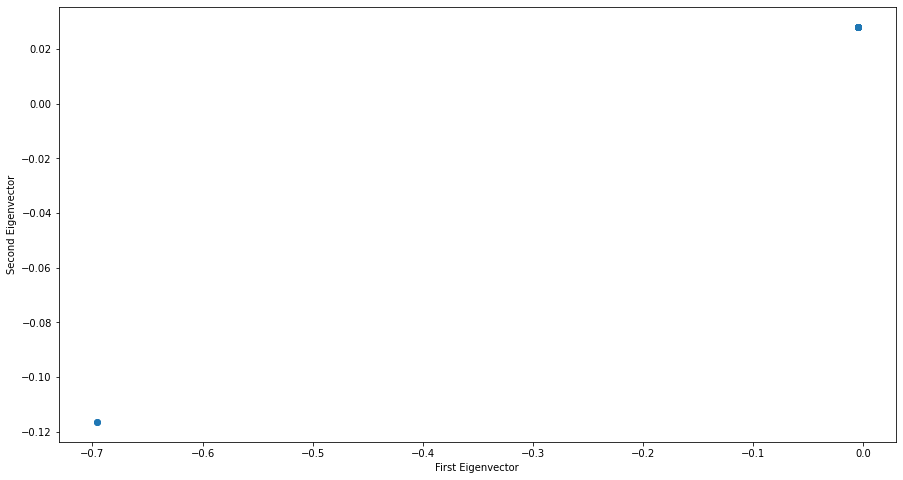

In [58]:
plt.figure(figsize=(15,8))
plt.scatter(vecsx[:, 0], vecsx[:, 1])
plt.xlabel('First Eigenvector')
plt.ylabel('Second Eigenvector')
plt.show()

In [128]:
#eigvals, eigvects for networkx Laplacian
valsx, vecsx = eigens(Lx, k=4)

#use columns 2 to k since first two columns correspond to eigen 0
vecsx = vecsx[:,2:]

In [174]:
k=14
sklkm = sklearnKMeans(n_clusters=k)
my_km = KMeans(k=k, distance_metric='eucl', verbose=False)

In [175]:
sklkm.fit(vecsx)
my_km.fit(vecsx)

In [176]:
# plt.subplots(nrows=1, ncols=2, figsize=(20,8))
# plt.subplot(121)
# ax=sns.distplot(sklkm.labels_, kde=False)
# patches = [x for x in ax.patches if x.get_height() > 0.1]
# for p in patches:
#     height = p.get_height()
#     ax.text(p.get_x()+p.get_width()/2.,
#             height + 3,
#             '{}'.format(int(height)),
#             ha="center") 

# plt.xticks(range(len(patches) ))
# plt.xlim([-0.5, len(patches) + 0.5])
# plt.title('SKLearns KMeans')
# plt.subplot(122)
# ax=sns.distplot(my_km.cluster_assignments, kde=False)
# patches = [x for x in ax.patches if x.get_height() > 0]
# for p in patches:
#     height = p.get_height()
#     ax.text(p.get_x()+p.get_width()/2.,
#             height + 3,
#             '{}'.format(int(height)),
#             ha="center") 

# plt.xlim([-0.5, len(patches) + 0.5])
# plt.xticks(range(len(patches) + 1))
# plt.title('SKLearns KMeans')
# plt.title('My KMeans')
# plt.show()

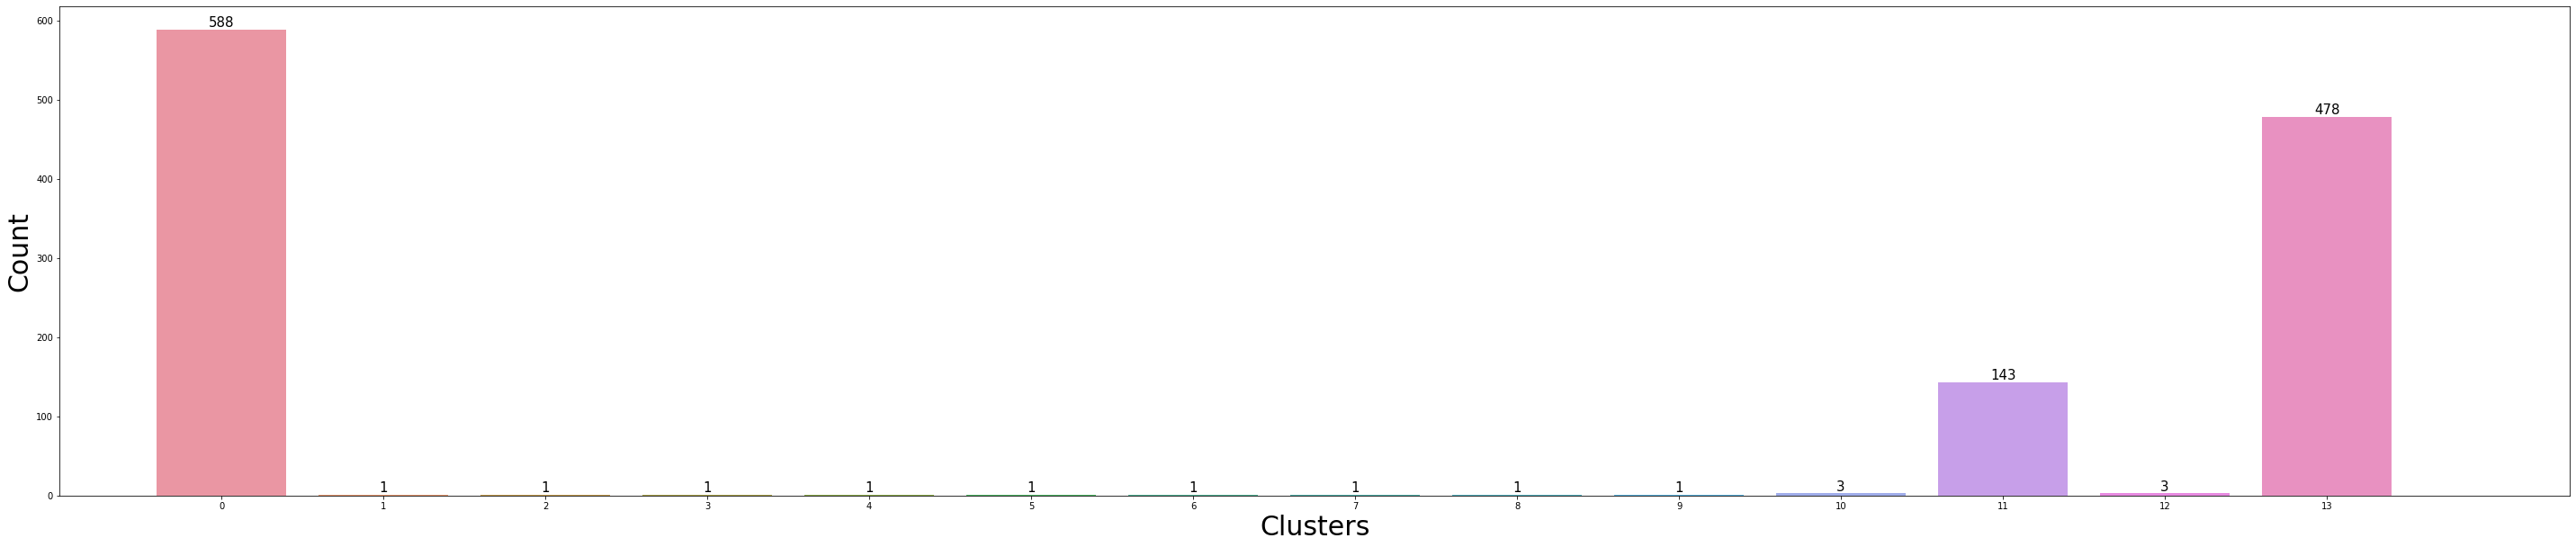

In [180]:
plt.figure(figsize=(50,10))
ax=sns.countplot(sklkm.labels_,)
ax.set_xlabel('Clusters', fontsize=30)
ax.set_ylabel('Count', fontsize=30)
patches = [x for x in ax.patches if x.get_height() > 0]
for p in patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{}'.format(int(height)),
            ha="center", size=15) 
    
ax.set_xlim(-1, k + 0.5)
plt.show()